# **Problem Statement**

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase has an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

- Here we are trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that we can predict and optimize the ad placement for our clients. 
- We have the data of 145k wikipedia pages and daily view count for each of them. 
- Our clients belong to different regions and need data on how their ads will perform on pages in different languages.


**Data Dictionary:**
- train_1.csv: 
    - In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.
    - The page name contains data in this format: SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
    - It has information about the page name, the main domain, the device type used to access the page, and also the request origin (spider or browser agent)

- Exog_Campaign_eng: 
    - This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.
    - There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

# **Loading dependencies and dataset**

In [1]:
# !pip install --upgrade setuptools

# !pip uninstall fbprophet

# Old
# !pip install pystan~=2.14
# !pip install fbprophet

# New
# !pip install pystan==2.19.1.1
# !pip install prophet

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape

In [3]:
df = pd.read_csv('./data/wiki_pages_ts.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# **Basic checks on the data**

In [4]:
df.shape

(145063, 551)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## **Missing Values**

In [6]:
df.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

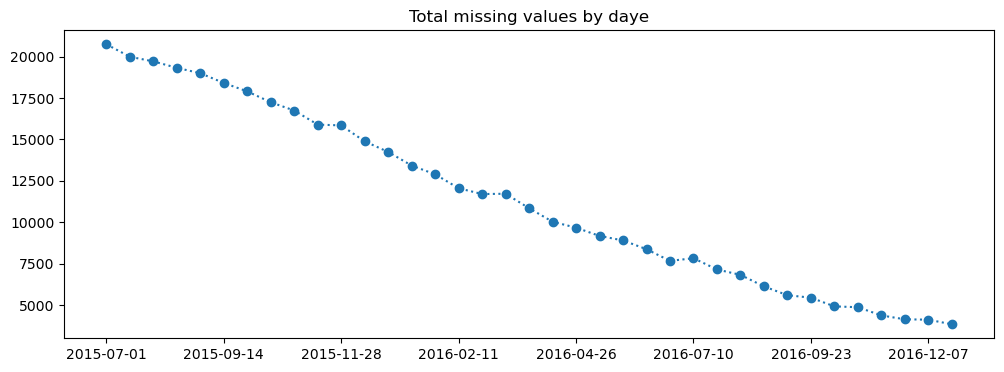

In [7]:
mon_dates = df.isna().sum().index[1::15]
plt.figure(figsize=(12, 4))
df.isna().sum()[mon_dates].plot(linestyle='dotted', marker='o')
plt.title('Total missing values by daye')
plt.show()

*Observations:*
- Null values are decreasing with time
- This is mostly because of the fact that newer pages have all null values before the date they got hosted

## **Dropping missing values**

In [8]:
df.shape

(145063, 551)

In [9]:
# No row or column has all values as nan
df.dropna(how='all').shape

(145063, 551)

In [10]:
# Dropping rows where >=30% of dates/columns are nan values
lim = int(0.70*551)
df.dropna(axis=0, thresh=lim).shape

(129637, 551)

In [11]:
# Fill nans with 0
df_final1 = df.dropna(axis=0, thresh=lim).copy()
df_final1.fillna(0, inplace=True)
df_final1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


In [12]:
# Checking null values post imputation
df_final1.isna().sum().loc[df_final1.isna().sum()>0]

Series([], dtype: int64)

# **EDA & Feature Engineering**

## **Language**

In [13]:
df_final2 = df_final1.copy()

# Checking another way of fetching the language out of the string
def lang(Page):
    val = re.search('[a-z][a-z].wikipedia.org',Page)
    if val:
        return val[0][0:2]

    return 'no_lang'

df_final2['Language']=df_final2['Page'].apply(lambda x: lang(str(x)))
lang_dict_ ={'de':'German', 'en':'English', 'es': 'Spanish', 'fr': 'French', 
             'ja': 'Japenese' , 'ru': 'Russian', 'zh': 'Chinese', 'no_lang': 'Unknown_Language'}
df_final2["Language"] = df_final2["Language"].map(lang_dict_)
df_final2['Language'].value_counts()

English             21635
Japenese            19032
German              16971
French              16607
Chinese             14521
Russian             14033
Unknown_Language    13523
Spanish             13315
Name: Language, dtype: int64

In [14]:
df_final2['Language'].isna().sum()

0

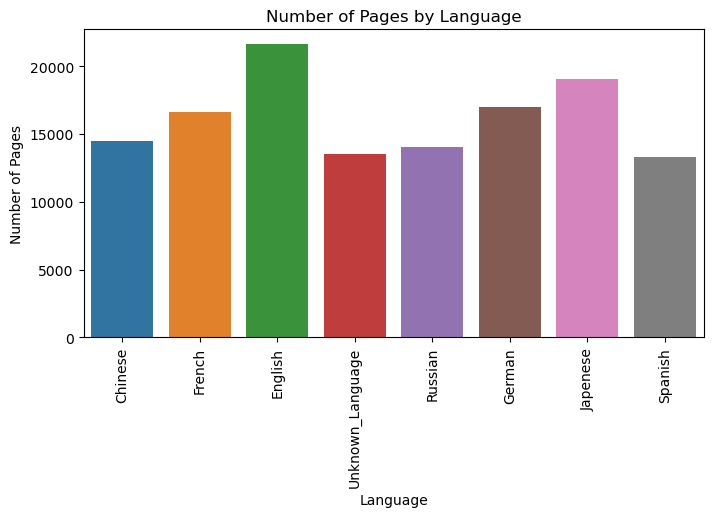

In [15]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_final2, x='Language')
plt.xlabel("Language")
plt.ylabel("Number of Pages")
plt.xticks(rotation=90)
plt.title("Number of Pages by Language")
plt.show()

## **Access_Type**

In [16]:
df_final2['Access_Type'] = df_final2['Page'].str.findall(r'all-access|mobile-web|desktop').apply(lambda x:x[0])
df_final2['Access_Type'].value_counts()

all-access    66619
mobile-web    32376
desktop       30642
Name: Access_Type, dtype: int64

In [17]:
df_final2['Access_Type'].isna().sum()

0

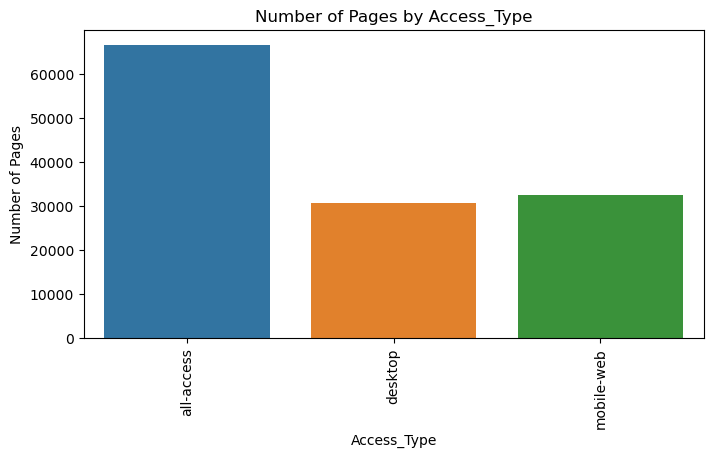

In [18]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_final2, x='Access_Type')
plt.xlabel("Access_Type")
plt.ylabel("Number of Pages")
plt.xticks(rotation=90)
plt.title("Number of Pages by Access_Type")
plt.show()

## **Access_Origin**

In [19]:
df_final2["Access_Origin"] =  df_final2['Page'].str.findall(r'spider|agents').apply(lambda x:x[0])
df_final2["Access_Origin"].value_counts()

agents    98228
spider    31409
Name: Access_Origin, dtype: int64

In [20]:
df_final2['Access_Origin'].isna().sum()

0

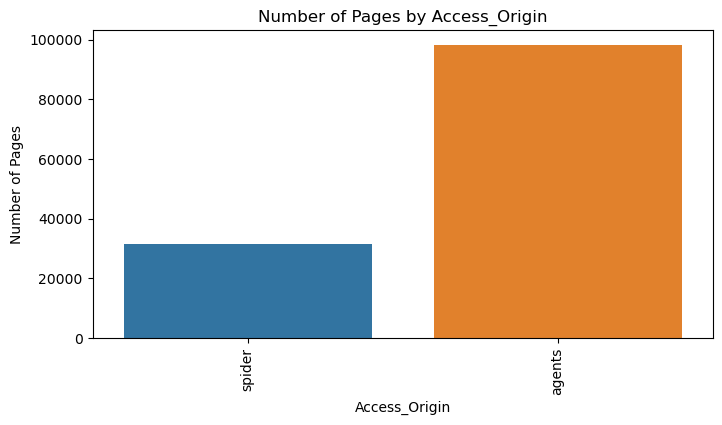

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_final2, x='Access_Origin')
plt.xlabel("Access_Origin")
plt.ylabel("Number of Pages")
plt.xticks(rotation=90)
plt.title("Number of Pages by Access_Origin")
plt.show()

## **Aggregated Data by Language: Daily Average Visits by Language**

In [22]:
aggregated_lang = df_final2.groupby("Language").mean().T.drop("Unknown_Language",axis = 1).reset_index()
aggregated_lang["index"] = pd.to_datetime(aggregated_lang["index"])
aggregated_lang = aggregated_lang.set_index("index")
aggregated_lang

Language,Chinese,English,French,German,Japenese,Russian,Spanish
index,,,,,,,
2015-07-01,285.441430,3915.490964,509.339315,781.362383,623.130727,674.398561,1147.149531
2015-07-02,285.865023,3902.839150,512.610164,770.719757,715.566730,686.069978,1096.256177
2015-07-03,283.968528,3705.436145,492.901367,739.733487,646.260193,635.888620,1008.194217
2015-07-04,286.714758,3857.753963,526.866321,678.824760,811.964901,598.103684,946.607135
2015-07-05,305.846980,3984.191911,517.275848,789.130104,778.970050,636.962517,1029.449944
...,...,...,...,...,...,...,...
2016-12-27,364.453757,6456.391125,847.461251,1124.183313,808.060950,1006.405829,1079.991513
2016-12-28,372.391640,6253.509406,775.665984,1066.646927,808.105244,952.443526,1120.484942
2016-12-29,342.734040,6684.139311,759.547299,1037.372930,885.470944,916.923252,1070.468194


In [23]:
aggregated_lang.shape

(550, 7)

In [24]:
aggregated_lang.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   550 non-null    float64
 1   English   550 non-null    float64
 2   French    550 non-null    float64
 3   German    550 non-null    float64
 4   Japenese  550 non-null    float64
 5   Russian   550 non-null    float64
 6   Spanish   550 non-null    float64
dtypes: float64(7)
memory usage: 34.4 KB


In [25]:
aggregated_lang.isna().sum()

Language
Chinese     0
English     0
French      0
German      0
Japenese    0
Russian     0
Spanish     0
dtype: int64

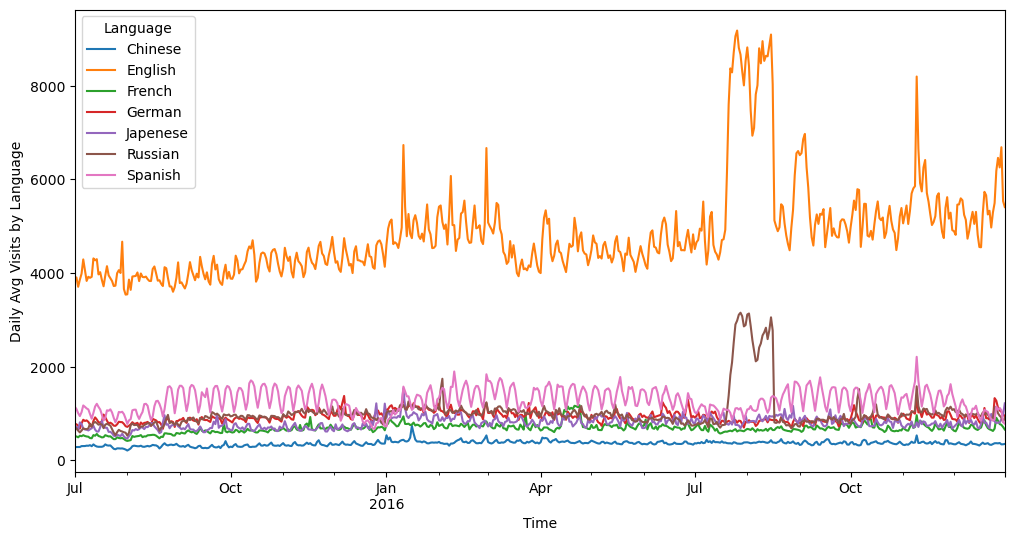

In [26]:
aggregated_lang.plot(figsize=(12,6))
plt.xlabel("Time")
plt.ylabel("Daily Avg Visits by Language")
plt.show()

# **Making Time Series Stationary: English**
- We do our analysis on the english time series first since it has the most number of daily average visits

In [27]:
agg_lang_eng = aggregated_lang['English']
agg_lang_eng

index
2015-07-01    3915.490964
2015-07-02    3902.839150
2015-07-03    3705.436145
2015-07-04    3857.753963
2015-07-05    3984.191911
                 ...     
2016-12-27    6456.391125
2016-12-28    6253.509406
2016-12-29    6684.139311
2016-12-30    5535.114352
2016-12-31    5407.217333
Name: English, Length: 550, dtype: float64

In [28]:
def Dickey_Fuller_test(ts,significances_level = 0.05):
    p_value = sm.tsa.stattools.adfuller(ts)[1]
    if p_value <= significances_level:
        print("Time Series is Stationary")
    else:
        print("Time Series is NOT Stationary")
    print("p_value is: ", p_value)

In [29]:
Dickey_Fuller_test(agg_lang_eng)

Time Series is NOT Stationary
p_value is:  0.13568970302456618


## **Visualization**

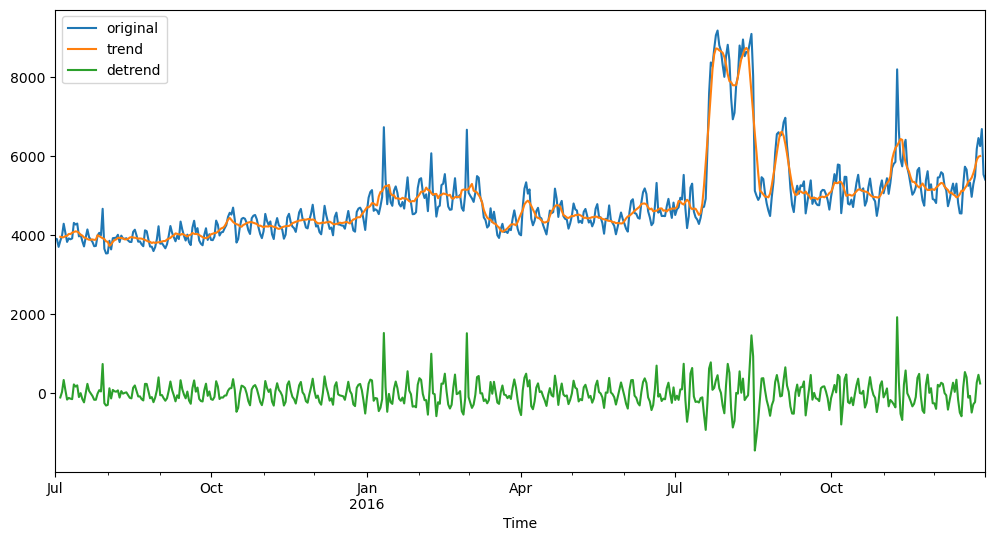

In [30]:
agg_lang_eng.plot(label='original', figsize=(12,6))
agg_lang_eng.rolling(7, center=True).mean().plot(label='trend', figsize=(12,6))
detrend_agg_lang_eng = agg_lang_eng - agg_lang_eng.rolling(7, center=True).mean()
detrend_agg_lang_eng.plot(label='detrend', figsize=(12,6))
plt.xlabel('Time')
plt.legend()
plt.show()

## **ACF of detrended series: Checking period for seasonality**

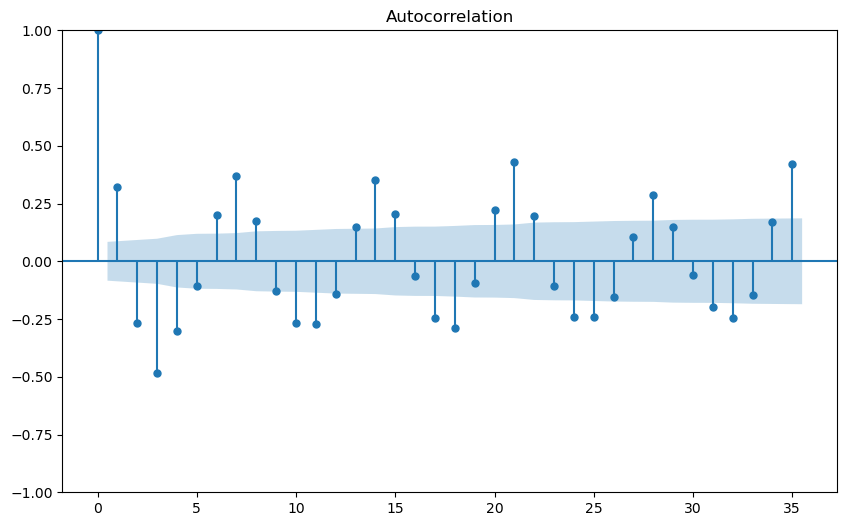

In [31]:
plt.rcParams['figure.figsize'] = (10, 6)
detrend_agg_lang_eng = agg_lang_eng - agg_lang_eng.rolling(7, center=True).mean()
plot_acf(detrend_agg_lang_eng.dropna(),lags=35);

## **Seasonal Decompose:**

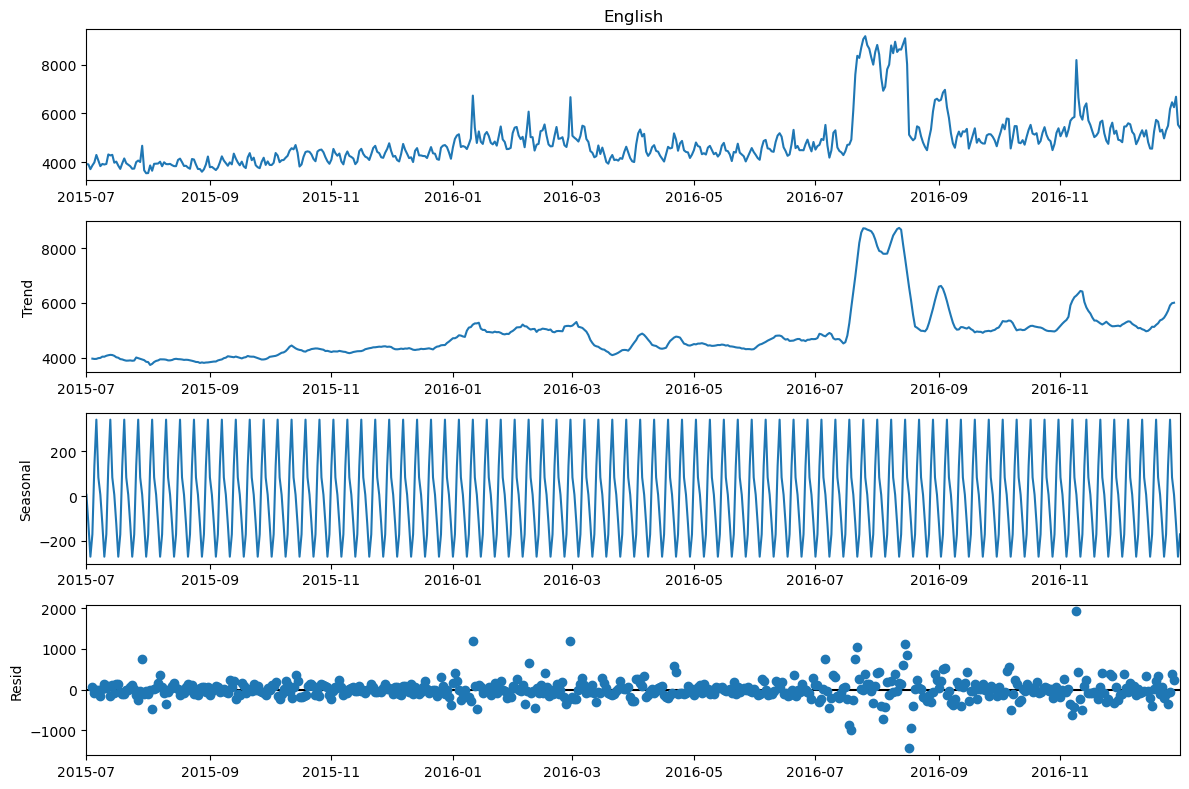

In [32]:
plt.rcParams['figure.figsize']=(12, 8)
decomposed_model = sm.tsa.seasonal_decompose(agg_lang_eng, model='additive', period=7)
decomposed_model.plot();

## **First Differenced Series (Order=1):**

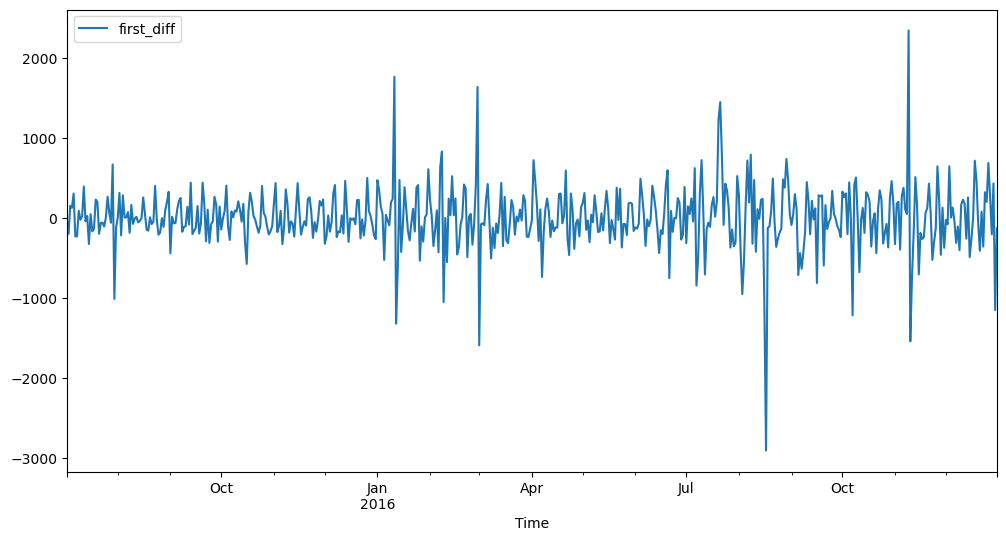

In [33]:
agg_lang_eng_diff = agg_lang_eng.diff(1)
agg_lang_eng_diff.dropna(inplace=True)
agg_lang_eng_diff.plot(label='first_diff', figsize=(12, 6))
plt.xlabel('Time')
plt.legend()
plt.show()

In [34]:
# Check stationarity of first differenced series
Dickey_Fuller_test(agg_lang_eng_diff)

Time Series is Stationary
p_value is:  5.098683633585129e-13


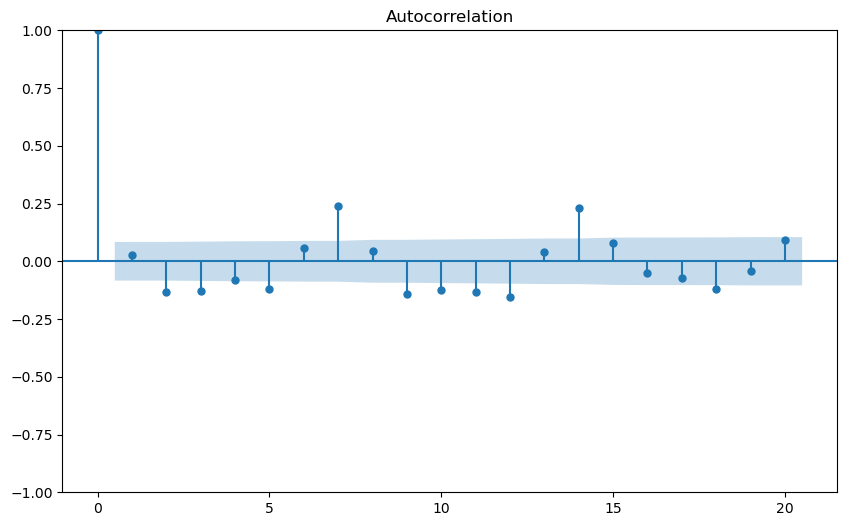

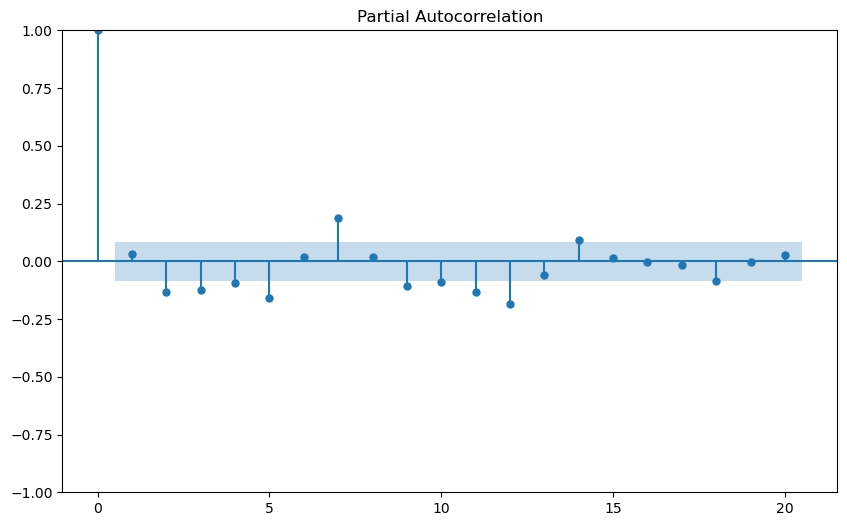

In [35]:
# Checking ACF and PACF
plt.rcParams['figure.figsize']=(10, 6)
acf=plot_acf(agg_lang_eng_diff,lags=20)
pacf=plot_pacf(agg_lang_eng_diff,lags=20)

In [36]:
# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

# **ARIMA: English**

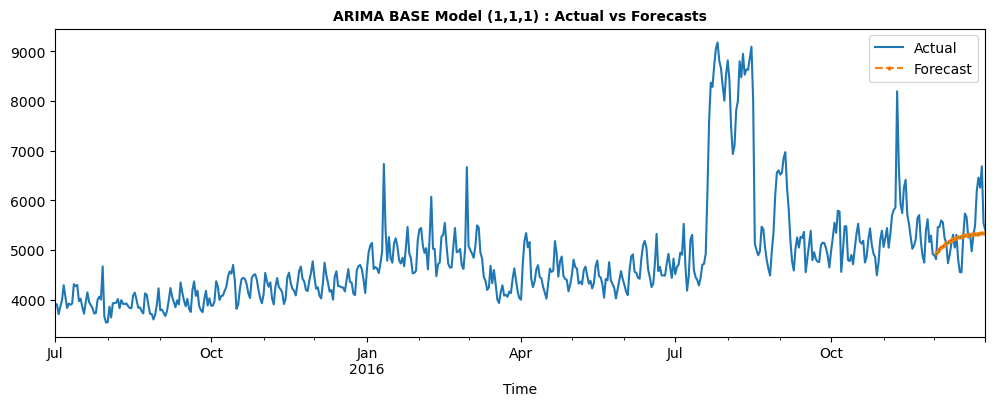

--------------------
Performance Metrics:
--------------------
MAE : 370.675
RMSE : 505.947
MAPE: 0.067
--------------------


In [37]:
n_forecast = 30
model = ARIMA(agg_lang_eng[:-n_forecast], order = (1,1,1))
model = model.fit()
predicted = model.forecast(steps= n_forecast, alpha = 0.05)

agg_lang_eng.plot(label = 'Actual')
predicted.plot(label = 'Forecast', linestyle='dashed', marker='o',markerfacecolor='green', markersize=2, figsize=(12, 4))
plt.xlabel('Time')
plt.title('ARIMA BASE Model (1,1,1) : Actual vs Forecasts', fontsize = 10, fontweight = 'bold')
plt.legend(loc="upper right")
plt.show()


# Metrics
print('-'*20)
print('Performance Metrics:')
print('-'*20)
performance(agg_lang_eng[-n_forecast:], predicted)
print('-'*20)

# **Introducing exogenous variable: English**

In [38]:
Exog_Campaign_eng = pd.read_csv('./data/Exog_Campaign_eng.csv')
Exog_Campaign_eng['index']=agg_lang_eng.index
Exog_Campaign_eng.set_index('index', inplace=True)
Exog_Campaign_eng = Exog_Campaign_eng['Exog']
# Exog_Campaign_eng.head()

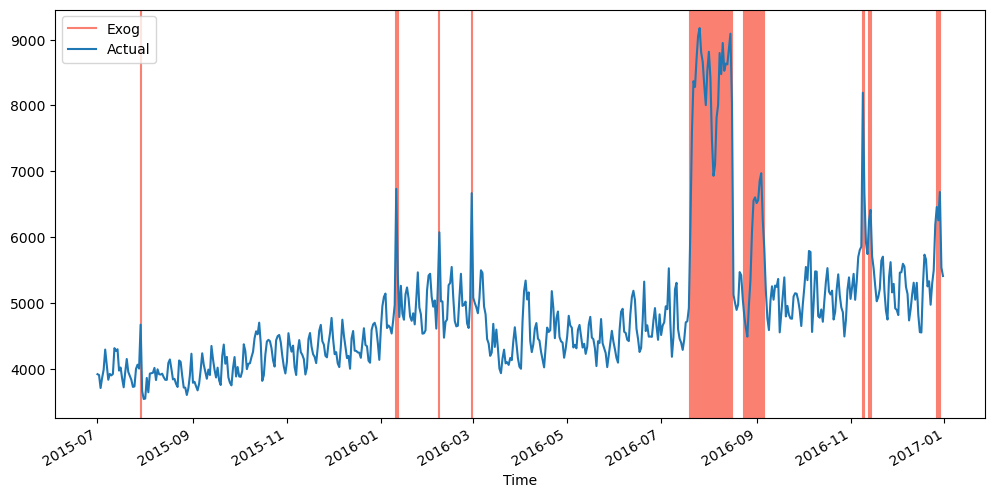

In [39]:
plt.figure(figsize=(12, 6))
for index in Exog_Campaign_eng.loc[Exog_Campaign_eng==1].index[:-1]: 
    plt.axvline(x=index, color='#FA8072')
plt.axvline(x=Exog_Campaign_eng.loc[Exog_Campaign_eng==1].index[-1], color='#FA8072', label='Exog')
agg_lang_eng.plot(label = 'Actual')
plt.xlabel('Time')
plt.legend(loc="upper left")
plt.show()

# **SARIMAX: English**

In [40]:
def sarimax_model(time_series, n=30, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog=[]):
    
    if len(exog)==0:
        exog=np.zeros(len(time_series))
        
    #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s) 
    model = SARIMAX(time_series[:-n],
                    order =(p,d,q), 
                    seasonal_order=(P, D, Q, s), 
                    exog = exog[:-n],
                    initialization='approximate_diffuse')
    model_fit = model.fit(disp=False)
    
    #Creating forecast for last n-values
    predicted = model_fit.forecast(n, dynamic=True, exog=pd.DataFrame(exog[-n:]))
    
    #plotting Actual & Forecasted values
    
    plt.figure(figsize = (12,4))
    time_series[-n-30:-n].plot(label = 'Training', marker='o')
    time_series[-n:].plot(label = 'Actual', marker='o')
    predicted[-n:].plot(label = 'Forecast', color = 'red', linestyle='dashed', marker='o', markerfacecolor='green')
    plt.xlabel('Time')
    plt.legend(loc="upper right")
    plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 10, fontweight = 'bold')
    plt.show()
    
    # Metrics
    print('-'*20)
    print('Performance Metrics:')
    print('-'*20)
    performance(time_series[-n_forecast:], predicted)
    print('-'*20)

## **SARIMAX without exogenous variable**

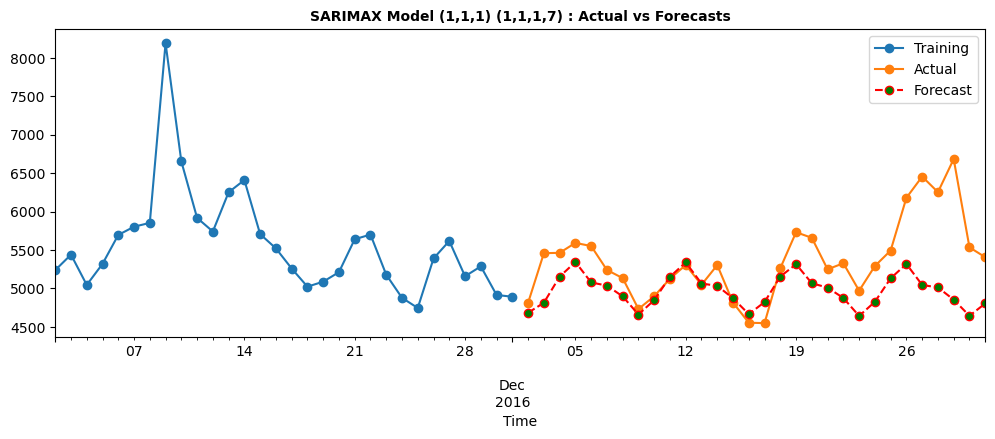

--------------------
Performance Metrics:
--------------------
MAE : 431.798
RMSE : 608.635
MAPE: 0.075
--------------------


In [41]:
# SARIMAX without exog variable
p,d,q,P,D,Q,s = 1,1,1,1,1,1,7
n=30
sarimax_model(agg_lang_eng, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s)

## **SARIMAX with exogenous variable**

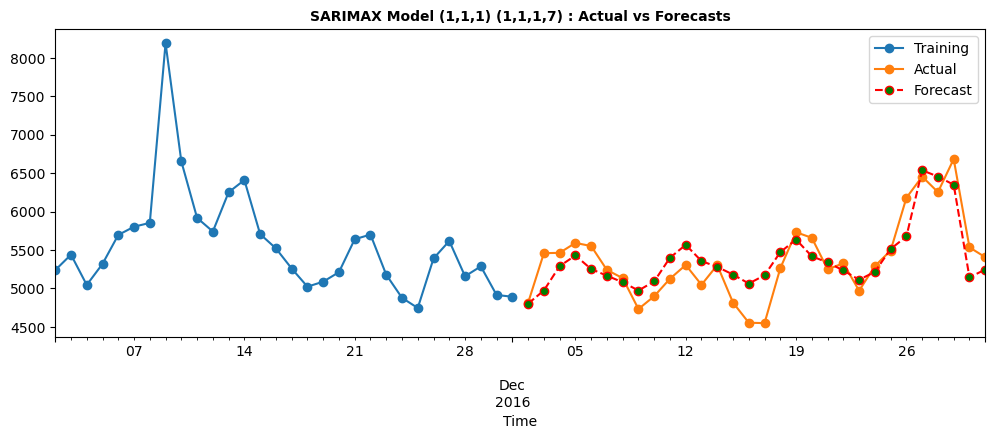

--------------------
Performance Metrics:
--------------------
MAE : 223.341
RMSE : 273.916
MAPE: 0.042
--------------------


In [42]:
# SARIMAX with exog variable
p,d,q,P,D,Q,s = 1,1,1,1,1,1,7
n=30
sarimax_model(agg_lang_eng, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog=Exog_Campaign_eng)

# **HyperParameter Tuning (SARIMAX): English**

In [43]:
def SARIMAX_grid_search(time_series, n, param, d_param, s_param, exog = []):
    
    if len(exog)==0:
        exog=np.zeros(len(time_series))
        
    counter = 0
    #creating df for storing results summary
    param_df = pd.DataFrame(columns = ['serial','pdq', 'PDQs', 'mape', 'rmse'])
    
    #Creating loop for every paramater to fit SARIMAX model
    for p in param:
        for d in d_param:
            for q in param:
                for P in param:
                    for D in d_param:
                        for Q in param:
                            for s in s_param:
                                #Creating Model
                                model = SARIMAX(time_series[:-n], 
                                                order=(p,d,q), 
                                                seasonal_order=(P, D, Q, s), 
                                                exog = exog[:-n],
                                                initialization='approximate_diffuse')
                                model_fit = model.fit(disp=False)
                                
                                #Creating forecast from Model
                                model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))
                                
                                #Calculating errors for results
                                actuals = time_series.values[-n:]
                                errors = time_series.values[-n:] - model_forecast.values
                                
                                #Calculating MAPE & RMSE
                                mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                rmse = np.sqrt(np.mean(errors**2))
                                mape = np.round(mape,5)
                                rmse = np.round(rmse,3)
                                
                                #Storing the results in param_df
                                counter += 1
                                list_row = [counter, (p,d,q), (P,D,Q,s), mape, rmse]
                                param_df.loc[len(param_df)] = list_row
                                
                #print statement to check progress of Loop                
                print(f'Possible Combination: {counter} out of { (len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')
                           
    return param_df  

In [44]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
# Suppress specific warnings by message
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
# Suppress general warnings by category
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [45]:
#Finding best parameters for English time series

exog = Exog_Campaign_eng
time_series = agg_lang_eng

n = 30
param = [0,1,2]
d_param = [0,1]
s_param = [7]

english_params  = SARIMAX_grid_search(time_series, n, param, d_param, s_param, exog=exog)

Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculated
Possible Combination: 324 out of 324 calculated


In [46]:
english_params.sort_values(['mape', 'rmse']).head()

,serial,pdq,PDQs,mape,rmse
190,191,"(1, 1, 1)","(1, 1, 1, 7)",0.04237,273.916
214,215,"(1, 1, 2)","(2, 1, 1, 7)",0.04318,281.027
215,216,"(1, 1, 2)","(2, 1, 2, 7)",0.04374,283.249
41,42,"(0, 0, 2)","(0, 1, 2, 7)",0.04385,298.122
47,48,"(0, 0, 2)","(1, 1, 2, 7)",0.04387,297.580


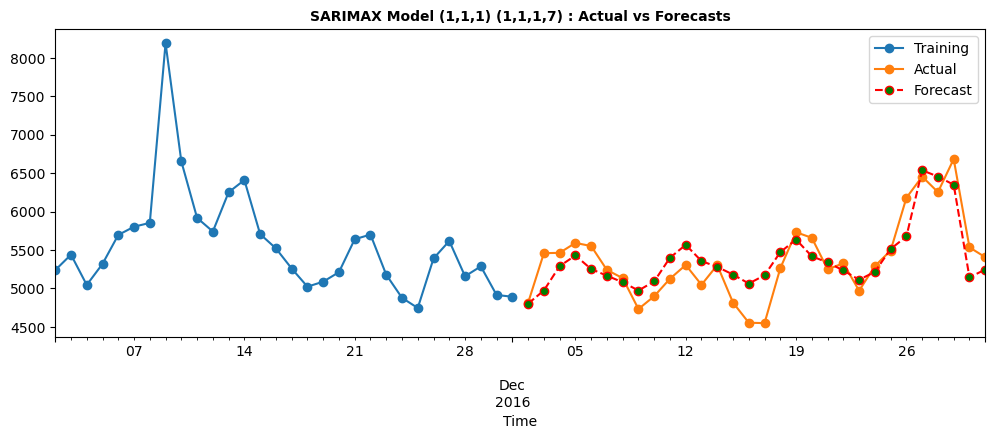

--------------------
Performance Metrics:
--------------------
MAE : 223.341
RMSE : 273.916
MAPE: 0.042
--------------------


In [47]:
exog = Exog_Campaign_eng
time_series = agg_lang_eng
p,d,q, P,D,Q,s = 1,1,1,1,1,1,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

# **HyperParameter Tuning (SARIMAX): Other Languages**

In [48]:
def pipeline_sarimax_grid_search_without_exog(languages, data, n, param, d_param, s_param):
    
    best_param_df  = pd.DataFrame(columns = ['language','p','d', 'q', 'P','D','Q','s','mape'])
    for lang in languages:
        print('')
        print('')
        print(f'--------------------------------------------------------------')
        print(f'          Finding best parameters for {lang}                  ')
        print(f'--------------------------------------------------------------')
        counter = 0
        time_series = data[lang]
        best_mape = 100
        
        #Creating loop for every paramater to fit SARIMAX model
        for p in param:
            for d in d_param:
                for q in param:
                    for P in param:
                        for D in d_param:
                            for Q in param:
                                for s in s_param:
                                    #Creating Model
                                    model = SARIMAX(time_series[:-n], 
                                                    order=(p,d,q), 
                                                    seasonal_order=(P, D, Q, s), 
                                                    initialization='approximate_diffuse')
                                    model_fit = model.fit(disp=False)

                                    #Creating forecast from Model
                                    model_forecast = model_fit.forecast(n, dynamic = True)

                                    #Calculating errors for results
                                    actuals = time_series.values[-n:]
                                    errors = time_series.values[-n:] - model_forecast.values

                                    #Calculating MAPE & RMSE
                                    mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                    
                                    counter += 1

                                    if (mape < best_mape):
                                        best_mape = mape
                                        best_p = p
                                        best_d = d
                                        best_q = q
                                        best_P = P
                                        best_D = D
                                        best_Q = Q
                                        best_s = s
                                    else: pass

                    #print statement to check progress of Loop                
                    print(f'Possible Combination: {counter} out of {(len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

        best_mape = np.round(best_mape, 5)
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {lang} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p , best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')
        
        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_mape]
        best_param_df.loc[len(best_param_df)] = best_param_row                
                           
    return best_param_df

In [49]:
langs = list(aggregated_lang.columns)
remv_item = langs.pop(1)
langs

['Chinese', 'French', 'German', 'Japenese', 'Russian', 'Spanish']

In [50]:
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]

best_param_df = pipeline_sarimax_grid_search_without_exog(langs, aggregated_lang, n, param, d_param, s_param)



--------------------------------------------------------------
          Finding best parameters for Chinese                  
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculat

In [51]:
best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,Chinese,0,1,1,0,0,2,7,0.03296
4,Russian,0,0,0,1,0,1,7,0.05383
1,French,0,0,2,2,1,2,7,0.05804
2,German,2,1,0,0,1,1,7,0.06686
3,Japenese,0,0,2,2,0,2,7,0.07189
5,Spanish,0,1,0,2,1,0,7,0.08238


# **Facebook Prophet: English**
- We use Facebook's Prophet to model our english time series

In [52]:
time_series_eng = pd.DataFrame(agg_lang_eng)
time_series_eng['holiday'] = Exog_Campaign_eng
time_series_eng = time_series_eng.reset_index()
time_series_eng.columns = ['ds', 'y', 'holiday']
time_series_eng.head()

,ds,y,holiday
0,2015-07-01,3915.490964,0
1,2015-07-02,3902.839150,0
2,2015-07-03,3705.436145,0
3,2015-07-04,3857.753963,0
4,2015-07-05,3984.191911,0


## **Prophet: Without exogeneous variable**

11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing


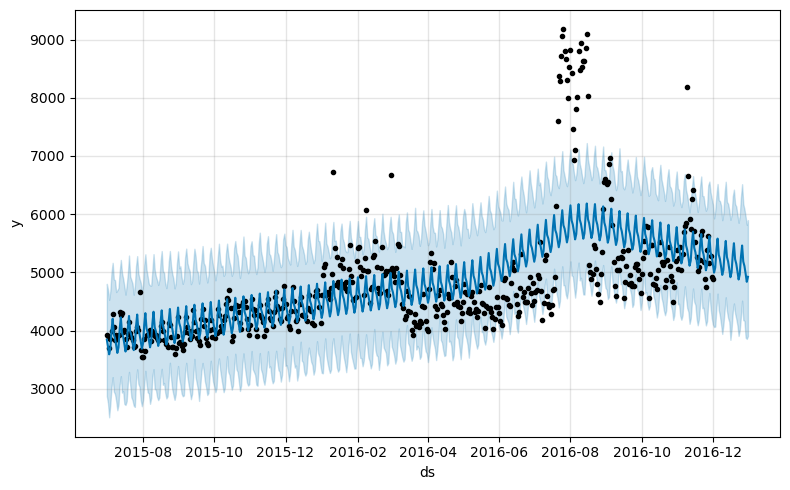

In [53]:
# Without exogeneous variable
train = time_series_eng[:-30]
test = time_series_eng[-30:]

prophet1 = Prophet(weekly_seasonality=True)
prophet1.fit(train[['ds', 'y']])
future = prophet1.make_future_dataframe(periods=30, freq='D')
forecast = prophet1.predict(future)
fig1 = prophet1.plot(forecast, figsize=(8, 5))

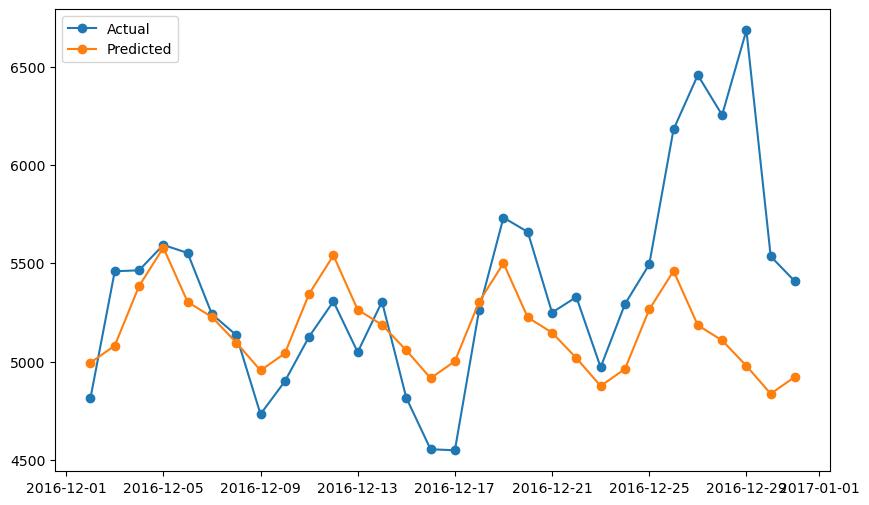

--------------------
Performance Metrics:
--------------------
MAE : 365.25
RMSE : 531.441
MAPE: 0.064
--------------------


In [54]:
# Actuals vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], marker='o', label='Actual')
plt.plot(forecast['ds'][-30:], forecast['yhat'][-30:], marker='o', label='Predicted')
plt.legend(loc='upper left')
plt.show()

# Metrics
print('-'*20)
print('Performance Metrics:')
print('-'*20)
performance(test['y'], forecast['yhat'][-30:])
print('-'*20)

## **Prophet: With exogeneous variable**

11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing


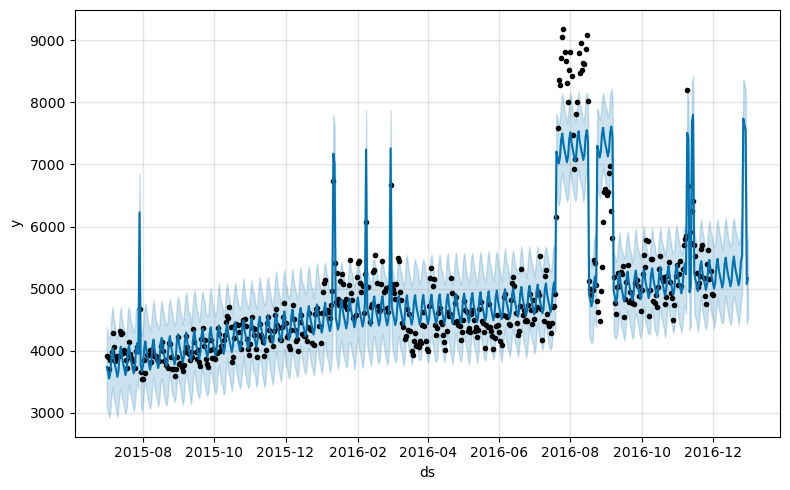

In [55]:
# With exogeneous variable
train = time_series_eng[:-30]
test = time_series_eng[-30:]

prophet2 = Prophet(weekly_seasonality=True)
prophet2.add_regressor('holiday') #adding holidays data in the model
prophet2.fit(train)
# future = prophet2.make_future_dataframe(periods=30, freq='D')
forecast = prophet2.predict(time_series_eng)
fig2 = prophet2.plot(forecast, figsize=(8, 5))

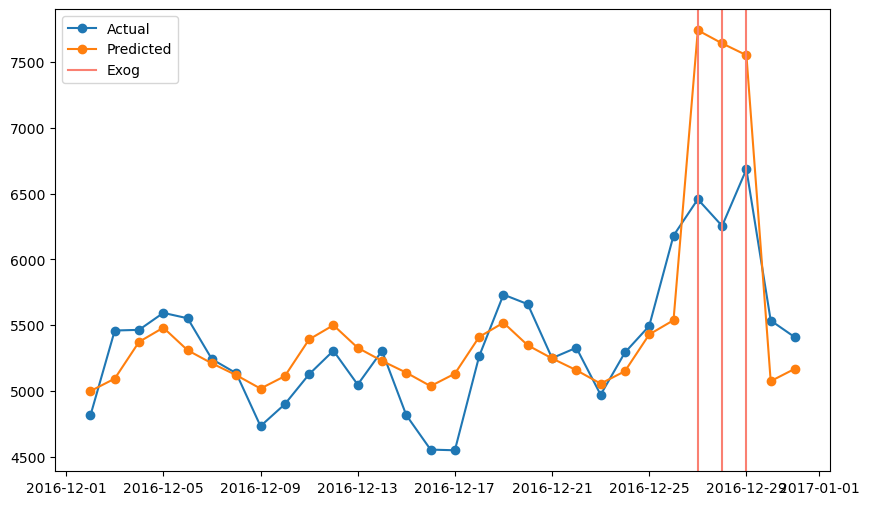

--------------------
Performance Metrics:
--------------------
MAE : 325.331
RMSE : 464.573
MAPE: 0.058
--------------------


In [56]:
# Actuals vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], marker='o', label='Actual')
plt.plot(forecast['ds'][-30:], forecast['yhat'][-30:], marker='o', label='Predicted')

# Plotting exog variable
exog_test = Exog_Campaign_eng[-30:]
for index in exog_test.loc[exog_test==1].index[:-1]: 
    plt.axvline(x=index, color='#FA8072')
plt.axvline(x=exog_test.loc[exog_test==1].index[-1], color='#FA8072', label='Exog')

plt.legend(loc='upper left')
plt.show()

# Metrics
print('-'*20)
print('Performance Metrics:')
print('-'*20)
performance(test['y'], forecast['yhat'][-30:])
print('-'*20)

# **Inferences and Recommendations:**

- Top3 inferences from data visualization:
    - Total 7 languages found in data.
    - English has the highest number of pages, maximum ads should be run on English Page.
    - 3 access types:
        - all-access 51%
        - mobile-web 25%
        - desktop 24%
    - 2 access origins:
        - agents 76%
        - spider 24%
---

- What does the decomposition of series do?
    - The decomposition of a time series refers to the process of separating a time series into its components, such as trend, seasonality, and residuals.
    - These components are intended to represent different underlying patterns in the data. The idea behind decomposition is to break down a complex time series into simpler components that can be more easily understood and analyzed.
    - Trend component represents the underlying pattern in the data over time, reflecting long-term changes.
    - Seasonality component represents regular patterns that repeat over a fixed interval, such as daily, weekly, or yearly.
    - Residual component represents the remaining random fluctuations in the data after removing the trend and seasonality components.
    - Decomposition is often used in time series analysis to identify and isolate different patterns in the data and to forecast future values. It is also used to remove seasonality and trend components from the data before applying statistical or machine learning models to the residuals, as this can help to improve the performance of these models.
---

- What level of differencing gave you a stationary series?
    - Stationarity is an important property of a time series because many time series analysis techniques assume that the time series is stationary.
    - A time series is stationary if its mean, variance, and autocorrelation structure are constant over time.
    - Differencing is a common technique used to make a time series stationary.
    - It involves subtracting the value of the time series at a previous time step from the current time step.
    - This can help to remove trend and seasonality components from the data, making it more stationary.
    - The order of differencing refers to the number of times the differencing operation is performed.
    - In this case study, differencing once yield a stationary time series.
---

- Difference between arima, sarima & sarimax.
    - ARIMA (AutoRegressive Integrated Moving Average) 
        - It is a statistical model for time series data that accounts for both autoregression (the use of past values to predict future values) and moving average (the use of the residuals of past predictions to predict future values).
        - It is a flexible method for modeling non-stationary time series data and can be used for both univariate and multivariate time series.
        - ARIMA models are denoted by the notations ARIMA(p, d, q), where p is the order of the autoregression component, d is the order of differencing used to make the time series stationary, and q is the order of the moving average component.
    - SARIMA (Seasonal AutoRegressive Integrated Moving Average) 
        - It is a variation of ARIMA that accounts for both seasonality and non-stationarity in time series data.
        - Seasonality refers to repeating patterns in the data over fixed time intervals, such as daily, weekly, or yearly. SARIMA models are denoted by the notations SARIMA(p, d, q)(P, D, Q, S), where p, d, and q are the same as in ARIMA models, P is the order of the seasonal autoregression component, D is the order of seasonal differencing, Q is the order of the seasonal moving average component, and S is the number of seasons in the data.
    - SARIMAX (Seasonal AutoRegressive Integrated Moving Average with exogenous regressors) 
        - It is an extension of SARIMA that allows for the inclusion of exogenous variables, or variables that are not part of the time series data, in the modeling process.
        - SARIMAX models are useful when the time series data is influenced by other variables that are not part of the time series data, and can provide more accurate forecasts.
        - SARIMAX models are denoted by the notations SARIMAX(p, d, q)(P, D, Q, S)x, where p, d, q, P, D, Q, and S are the same as in SARIMA models and x represents the number of exogenous variables included in the model.     
---

- Compare the number of views in different languages

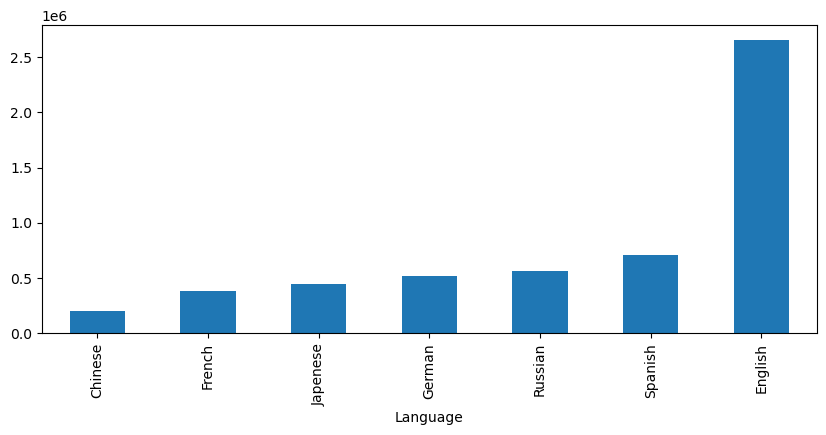

In [57]:
aggregated_lang.sum().sort_values().plot(kind = 'bar', figsize=(10, 4))
plt.show()

---

- What other methods other than grid search would be suitable to get the model for all languages?
    - When estimating the values of p, q, and d from the ACF and PACF plots of a time series, the following steps can be taken:
        - Determine if the time series is stationary by conducting an augmented Dickey-Fuller test.
        - If the time series is stationary, attempt to fit an ARMA model. If it is non-stationary, determine the value of d.
        - If stationarity is achieved, plot the autocorrelation and partial autocorrelation graphs of the data.
        - Plot the partial autocorrelation graph (PACF) to determine the value of p, as the cut-off point in the PACF is equal to p.
        - Plot the autocorrelation graph (ACF) to determine the value of q, as the cut-off point in the ACF is equal to q.
